Q1) Implement a sample CNN with one or
more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to
implement the self-attention layer yourself and use it in the forward function defined by you. All
other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The
network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and
1x GAP). Please refer to the reading material provided here or any other similar one. [10 Marks]

# **Importing necessary Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# **Self-Attention Module**

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, activation):
        super(SelfAttention, self).__init__()
        #define three 1*1 conv layers to create key,query,value.

        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)

        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)

        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

        self.activation = activation

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # Projecting the input features to query, key, and value spaces
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # B x (N) x C

        proj_key = self.key_conv(x).view(batch_size, -1, width * height)  # B x C x (N)

        energy = torch.bmm(proj_query, proj_key)  # batch matrix-matrix product

        attention = F.softmax(energy, dim=-1)  # normalize the attention scores

        proj_value = self.value_conv(x).view(batch_size, -1, width * height)  # B x C x (N)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # batch matrix-matrix product

        out = out.view(batch_size, channels, width, height)  # restore spatial structure

        out = self.gamma * out + x
        out = self.activation(out)
        return out


# **Self-AttentionCNN Module**

In [3]:
class SelfAttentionCNN(nn.Module):
    def __init__(self):
        super(SelfAttentionCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.sa1 = SelfAttention(32, activation=nn.ReLU())
        self.sa2 = SelfAttention(64, activation=nn.ReLU())
        self.sa3 = SelfAttention(128, activation=nn.ReLU())
        self.sa4 = SelfAttention(256, activation=nn.ReLU())

        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.sa1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.sa2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.sa3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.sa4(x)

        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

# **Runnable**

Files already downloaded and verified
Files already downloaded and verified
[1,  1563] loss: 0.698
Accuracy on the test set: 59.35 %
[2,  1563] loss: 0.539
Accuracy on the test set: 68.68 %
[3,  1563] loss: 0.469
Accuracy on the test set: 71.07 %
[4,  1563] loss: 0.400
Accuracy on the test set: 74.68 %
[5,  1563] loss: 0.343
Accuracy on the test set: 74.98 %
[6,  1563] loss: 0.299
Accuracy on the test set: 76.70 %
[7,  1563] loss: 0.277
Accuracy on the test set: 77.24 %
[8,  1563] loss: 0.233
Accuracy on the test set: 76.79 %
[9,  1563] loss: 0.212
Accuracy on the test set: 76.20 %
[10,  1563] loss: 0.176
Accuracy on the test set: 76.44 %
[11,  1563] loss: 0.124
Accuracy on the test set: 76.46 %
[12,  1563] loss: 0.138
Accuracy on the test set: 76.40 %
[13,  1563] loss: 0.122
Accuracy on the test set: 76.40 %
[14,  1563] loss: 0.094
Accuracy on the test set: 77.32 %
[15,  1563] loss: 0.091
Accuracy on the test set: 77.15 %


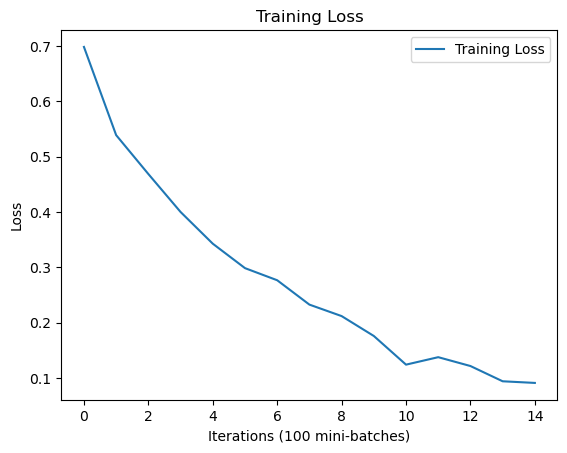

Finished Training


In [23]:
# Testing the network
import torchvision
import torchvision.transforms as transforms

# Data Processing and loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = SelfAttentionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

accuracies = []
train_losses = []
test_losses = []
maxEpoch = 15
for epoch in range(maxEpoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            running_loss = 0.0
    train_losses.append(running_loss / 100)
    print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 100))

    # Evaluate the network on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    print('Accuracy on the test set: %.2f %%' % (100 * correct / total))

# Plotting the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations (100 mini-batches)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

print('Finished Training')









# **Q2.) Object Recognition with Vision Transformer**

Implement and train an Encoder only Trans-
former (ViT-like) for the above object recognition task. In other words, implement multi-headed
self-attention for the image classification (i.e., appending a < class > token to the image patches
that are accepted as input tokens). Compare the performance of the two implementations (try to
keep the number of parameters to be comparable and use the same amount of training and testing
data). [10 Marks]


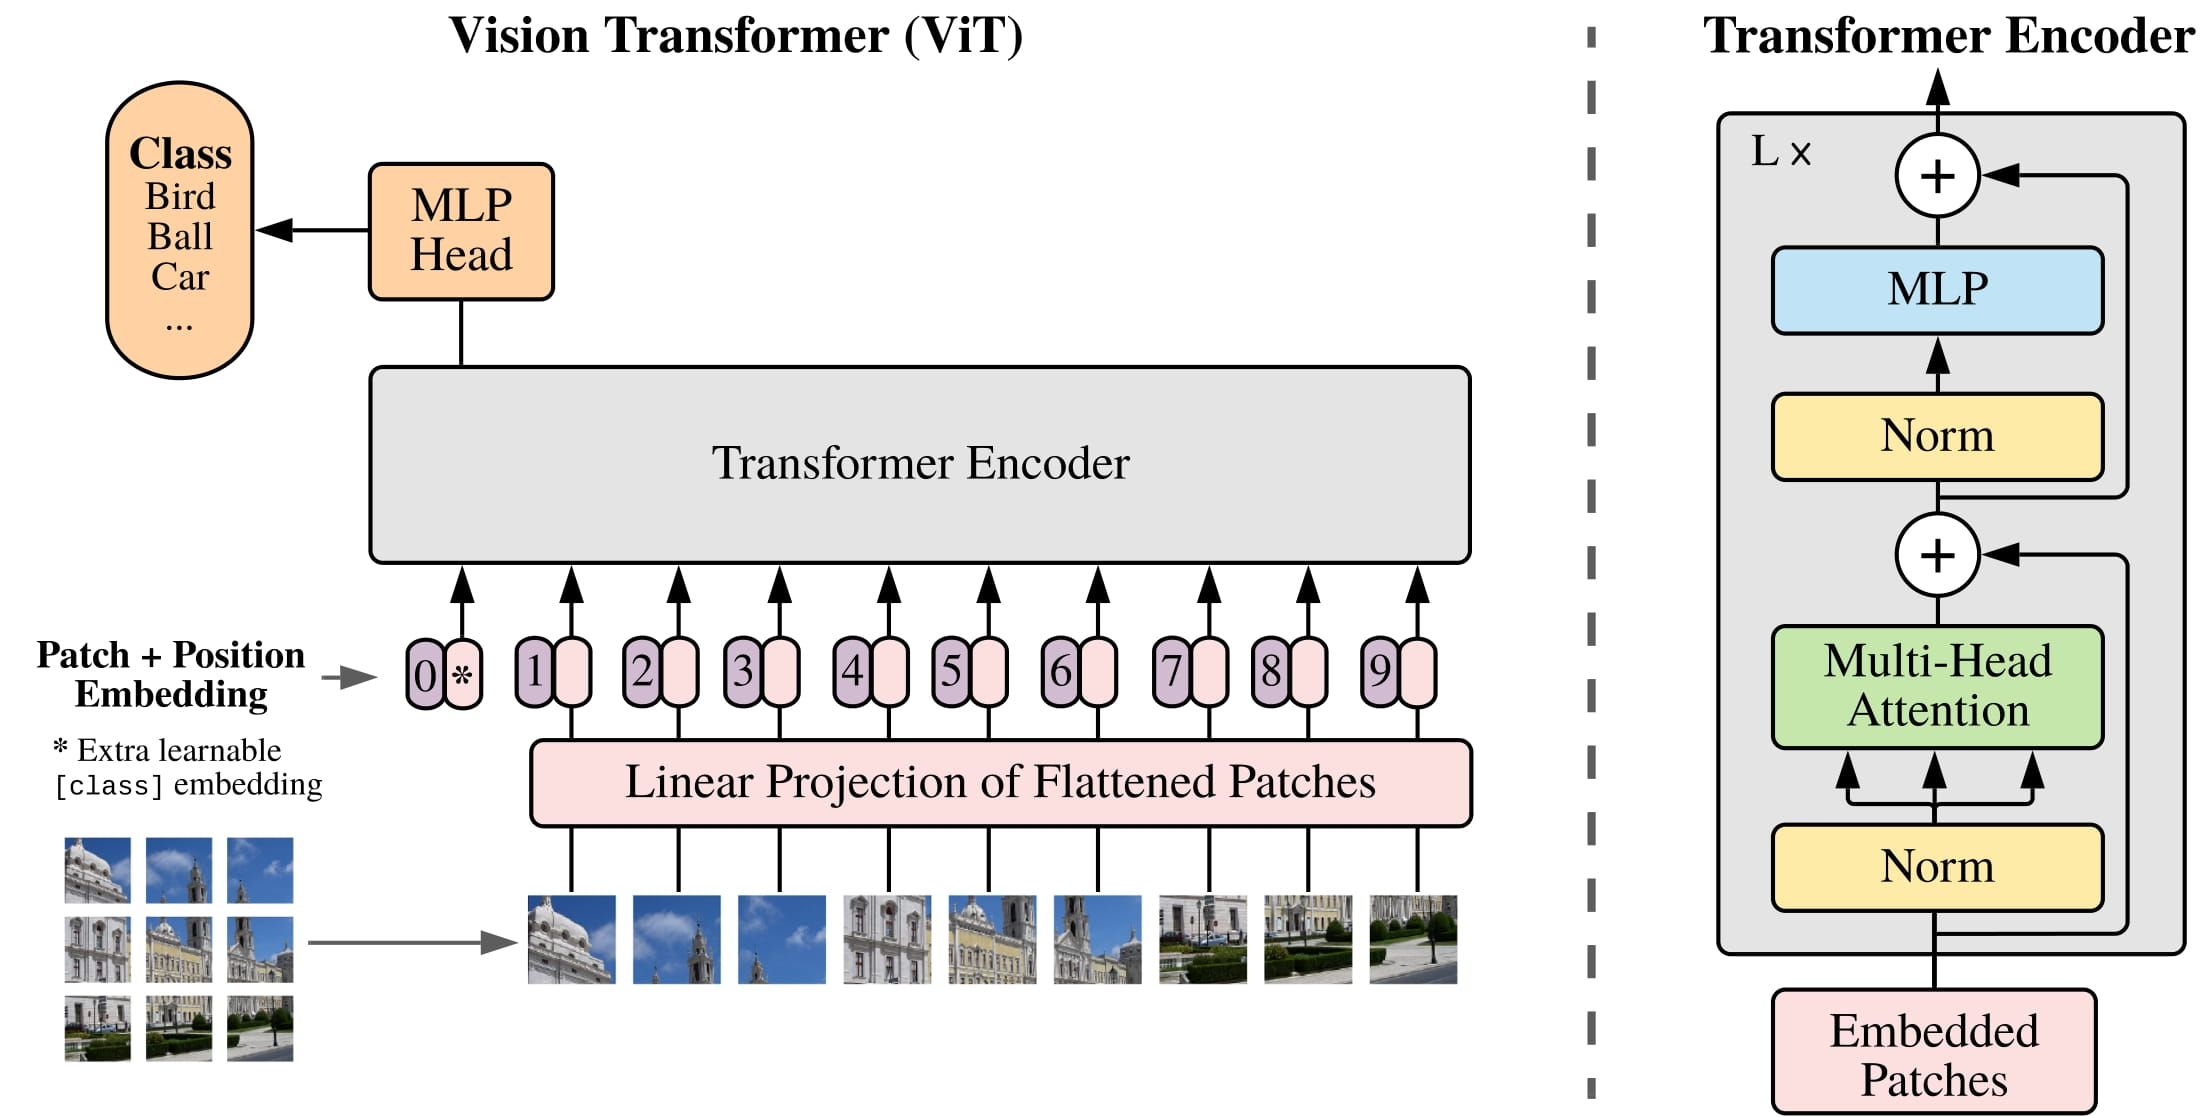


# **Importing the necessary libraries**

In [5]:
import torch
import math
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# **Initializing the Parameters**

In [6]:
# Model parameters

# Size of input images (assuming CIFAR-10)
image_size = 32

# Size of each patch
patch_size = 4

# Assuming RGB images
num_patches = (image_size // patch_size) ** 2
patch_dim = 3 * patch_size ** 2

# Number of classes in CIFAR-10
num_classes = 10

# Hidden size of the transformer layers
hidden_size = 256

# Number of transformer layers
num_layers = 2

# Number of attention heads
number_of_heads = 8

# **Multi-Head Self-Attention Module**

In [13]:
# Multi-Head Self-Attention Module
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, number_of_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert hidden_size % number_of_heads == 0, "hidden_size must be divisible by num_heads"

        self.hidden_size = hidden_size
        self.number_of_heads = number_of_heads
        self.head_dim = hidden_size // number_of_heads

        # Linear transformations for query, key, and value
        self.query_transform = nn.Linear(hidden_size, hidden_size)
        self.key_transform = nn.Linear(hidden_size, hidden_size)
        self.value_transform = nn.Linear(hidden_size, hidden_size)

        # Final linear layer
        self.fc_out = nn.Linear(hidden_size, hidden_size)

        # Scaling factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))

    def forward(self, query, key, value, mask=None):
        # Ensure all tensors are on the same device as query
        device = query.device

        batch_size = query.shape[0]

        # Linear transformations
        Q = self.query_transform(query).view(batch_size, -1, self.number_of_heads, self.head_dim).to(device)
        K = self.key_transform(key).view(batch_size, -1, self.number_of_heads, self.head_dim).to(device)
        V = self.value_transform(value).view(batch_size, -1, self.number_of_heads, self.head_dim).to(device)

        scale = self.scale.to(device)

        # Transpose for matrix multiplication

        # (batch_size, num_heads, seq_len, head_dim)
        Q = Q.permute(0, 2, 1, 3)

        # (batch_size, num_heads, seq_len, head_dim)
        K = K.permute(0, 2, 1, 3)

        # (batch_size, num_heads, seq_len, head_dim)
        V = V.permute(0, 2, 1, 3)

        # Attention scores
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / scale

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-inf"))

        # Softmax to get attention weights
        attention = torch.softmax(energy, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)

        # Apply attention to values
        x = torch.matmul(attention, V)

        # Reshape and concatenate heads
        x = x.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, num_heads, head_dim)
        x = x.view(batch_size, -1, self.hidden_size)  # (batch_size, seq_len, hidden_size)

        # Final linear layer
        x = self.fc_out(x)

        return x



# **Implementing Encoder Layer**

In [14]:

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(EncoderLayer, self).__init__()

        # Multi-Head Self-Attention Module
        self.self_attention = MultiHeadSelfAttention(hidden_size, num_heads)

        # Layer normalization for the first sublayer
        self.layer_norm1 = nn.LayerNorm(hidden_size)

        # Feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, 2 * hidden_size),
            nn.ReLU(),
            nn.Linear(2 * hidden_size, hidden_size)
        )

        # Layer normalization for the second sublayer
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        # Multi-Head Self-Attention
        attention_output = self.self_attention(x, x, x)

        # Add & Norm for the first sublayer
        x = self.layer_norm1(x + attention_output)

        # Feedforward
        feedforward_output = self.feedforward(x)

        # Add & Norm for the second sublayer
        x = self.layer_norm2(x + feedforward_output)

        return x



# **Positional Encoding Module**

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, hidden_size, max_len=10000):
        super(PositionalEncoding, self).__init__()

        # Create positional embeddings
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))

        # Compute sine and cosine positional encodings
        pos_encoding = torch.zeros(1, max_len, hidden_size)
        pos_encoding[0, :, 0::2] = torch.sin(position * div_term)
        pos_encoding[0, :, 1::2] = torch.cos(position * div_term)

        # Register positional embeddings as a buffer
        self.register_buffer('pos_encoding', pos_encoding[:, :num_patches, :])

    def forward(self, x):
        # Add positional encodings to the input
        return x + self.pos_encoding

# **Transformer Module**

In [16]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_patches, patch_dim, num_classes, hidden_size, num_layers, number_of_heads):
        super(VisionTransformer, self).__init__()

        # Patch Embedding Layer
        self.patch_embedding = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=patch_size, stride=patch_size)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(num_patches=num_patches + 1, hidden_size=hidden_size)

        # Encoder Layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(hidden_size, number_of_heads)
            for _ in range(num_layers)
        ])

        # Classification Head
        self.classification_head = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Patching and Embedding
        x = self.patch_embedding(x)  # (batch_size, hidden_size, num_patches, num_patches)
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, hidden_size)

        # Add class token
        batch_size = x.size(0)
        class_token = self.positional_encoding.pos_encoding[:, 0:1, :].expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)

        # Transformer Encoder
        for layer in self.encoder_layers:
            x = layer(x)

        # Classification
        x = x[:, 0, :]  # Only take the class token
        x = self.classification_head(x)

        return x


# **Runnable**

In [20]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize inputs
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=225, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=225, shuffle=False)

# Instantiate the model and move it to the appropriate device
model = VisionTransformer(image_size, patch_size, num_patches, patch_dim, num_classes, hidden_size, num_layers, number_of_heads).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

maxEpoch = 15


# Lists to store training loss and test accuracy
train_losses = []
test_accuracies = []


# Training loop
model.train()
for epoch in range(maxEpoch):
    running_loss = 0.0
    for images, labels in train_loader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{maxEpoch}, Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    # Evaluation
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    accuracy = correct_predictions / total_samples
    print(f"Accuracy on test set: {accuracy:.2%}")
    test_accuracies.append(accuracy)




cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Loss: 1.7133
Accuracy on test set: 45.81%
Epoch 2/15, Loss: 1.4181
Accuracy on test set: 50.38%
Epoch 3/15, Loss: 1.3052
Accuracy on test set: 51.46%
Epoch 4/15, Loss: 1.2443
Accuracy on test set: 52.56%
Epoch 5/15, Loss: 1.1856
Accuracy on test set: 54.85%
Epoch 6/15, Loss: 1.1307
Accuracy on test set: 56.13%
Epoch 7/15, Loss: 1.0957
Accuracy on test set: 57.01%
Epoch 8/15, Loss: 1.0562
Accuracy on test set: 56.26%
Epoch 9/15, Loss: 1.0060
Accuracy on test set: 57.76%
Epoch 10/15, Loss: 0.9725
Accuracy on test set: 58.12%
Epoch 11/15, Loss: 0.9379
Accuracy on test set: 57.99%
Epoch 12/15, Loss: 0.9067
Accuracy on test set: 59.24%
Epoch 13/15, Loss: 0.8718
Accuracy on test set: 58.66%
Epoch 14/15, Loss: 0.8383
Accuracy on test set: 58.17%
Epoch 15/15, Loss: 0.8047
Accuracy on test set: 57.69%


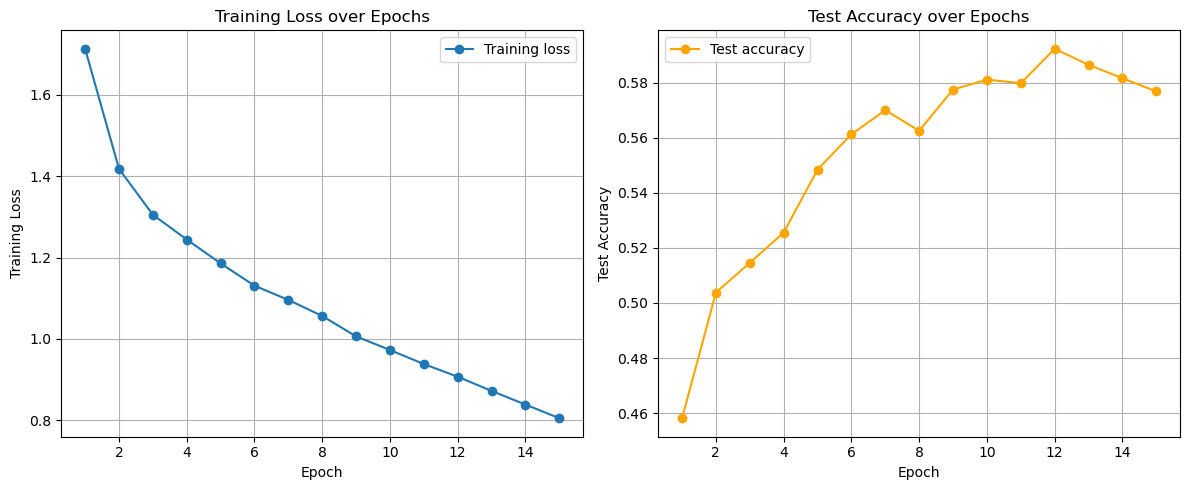

In [21]:


# Plotting
epochs = range(1, maxEpoch + 1)

plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, '-o', color='orange', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

References :

1) https://medium.com/machine-intelligence-and-deep-learning-lab/vit-vision-transformer-cc56c8071a20

2) https://www.v7labs.com/blog/vision-transformer-guide

3) https://www.youtube.com/watch?v=tRQ0EaqeJAI&t=1s

4) https://github.com/junawaneshivani/VisionTransformer/blob/main/vit_from_scratch.ipynb
